In [236]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

1. Download the dataset from kaggle (see the link in the notebook). Load it into a pandas dataframe (see the code in the notebook). Normalise the data.
2. Complete the code for the implementation of the methods \verb|predict|, \verb|cost|, \verb|gradient_cost|, \verb|accuracy|. As a test, just invoke the method by suitable dummy values.
3. Implement (full) batch GD for minimizing the CE cost (without autograd). Plot cost vs the number of epochs.
4. Implement (full) batch GD for minimizing the CE cost, this time with autograd. show that you obtain consistent results.
5. Tune the learning rate. What is a reasonable learning rate?

### 1. Load Data

In [237]:
import pandas as pd
df = pd.read_csv("./data/Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


#### Normalization and Turning into Torch Tensors

In [238]:
x0 = torch.from_numpy(df.values[:,0:-1].astype(np.float64))
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)
Y = torch.tensor(('Abnormal'==df.values[:,-1])).int().reshape(-1,1)
print(X.shape, Y.shape)

torch.Size([310, 12]) torch.Size([310, 1])


### 2. Implement the Model for (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [239]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)
print(X.shape)

torch.Size([310, 13])


In [240]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def predict(X,W):
    # YOUR CODE (START)
    return torch.sigmoid(X@W.T)
    # YOUR CODE (END)

def cost(X,Y,W):
    # YOUR CODE (START) 
    Yhat = predict(X, W)
    return -torch.mean(Y*torch.log(Yhat)+(1-Y)*torch.nan_to_num(torch.log(1-Yhat), neginf=-999))
    # YOUR CODE (END)

$\frac{\partial L_{\mathrm{CE}}}{\partial W_{i j}}=\left(s_i-u_i\right) x_j, \quad \frac{\partial L_{\mathrm{CE}}}{\partial b_i}=\left(s_i-u_i\right)$

In Matrix Notation we get $\operatorname{grad}_{\mathrm{W}}=\mathrm{X}^{\mathrm{T}}(\mathrm{S}-\mathrm{U})$, where $S$ = Matrix of the predictions (yhat) and $U$ = one hot encoded vector of acutal labels = Y


In [241]:
def gradient_cost(X,Y,W):
    # YOUR CODE (START)
    Yhat = predict(X, W)
    gradient = X.T@(Yhat-Y)
    return gradient.reshape(1,-1)
    # YOUR CODE (END)

def accuracy(Y,Yhat):
    # YOUR CODE (START)
    return torch.sum(torch.round(Yhat) == Y)/Y.shape[0]
    # YOUR CODE (END)

Just for testing:

In [242]:
W = torch.randn((1,13), dtype=torch.double)
print(predict(X[0],W))
print(cost(X,Y,W))
print(gradient_cost(X,Y,W))
print(accuracy(Y,predict(X,W)))

tensor([0.0872], dtype=torch.float64)
tensor(0.7485, dtype=torch.float64)
tensor([[-35.1023,  -8.8252,  -9.7964, -17.9139,  -4.0281,  35.3836, -22.2446,
         -30.7394,  41.3939, -36.0256,  29.9127,  10.5636, -25.6599]],
       dtype=torch.float64)
tensor(0.6323)


### 3. Implement Full Batch Gradient Descent

Training Accuracy (max,end): 0.848387, 0.819355
Training Cost (end): 88.991389


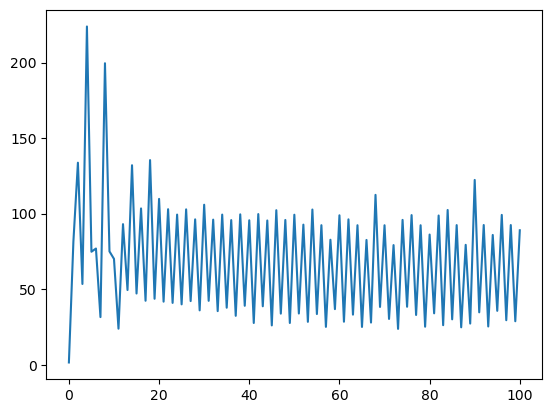

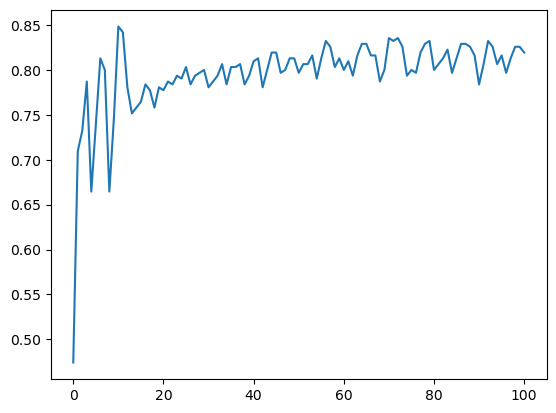

In [243]:
# adjust if needed
nepochs = 100
lr = 1.0

## initial parameter
W = torch.randn((1,13), dtype=torch.double)

# track the costs
costs = [cost(X,Y,W)]
accs = [accuracy(Y,predict(X,W))]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    W = W - lr * gradient_cost(X,Y,W)
    c = cost(X,Y,W)
    costs.append(c)
    accs.append(accuracy(Y,predict(X,W)))

# YOUR CODE (END)
# some output
accs = np.array(accs)

print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1].item())
plt.figure(1)
plt.plot(range(nepochs+1),costs)
plt.figure(2)
plt.plot(range(nepochs+1),accs)

### 4. Implement Full Batch Gradient Descent with Full-Fledge PyTorch

epoch: 10, loss = 0.6180146529427982
epoch: 20, loss = 0.6090974044782973
epoch: 30, loss = 0.6008421102049158
epoch: 40, loss = 0.5931818168585545
epoch: 50, loss = 0.5860575105437226
epoch: 60, loss = 0.5794170871518804
epoch: 70, loss = 0.573214458844253
epoch: 80, loss = 0.567408780283769
epoch: 90, loss = 0.5619637794524143
epoch: 100, loss = 0.5568471792983835
Training Accuracy (max,end): 0.725806, 0.725806
Training Cost (end): 0.556847


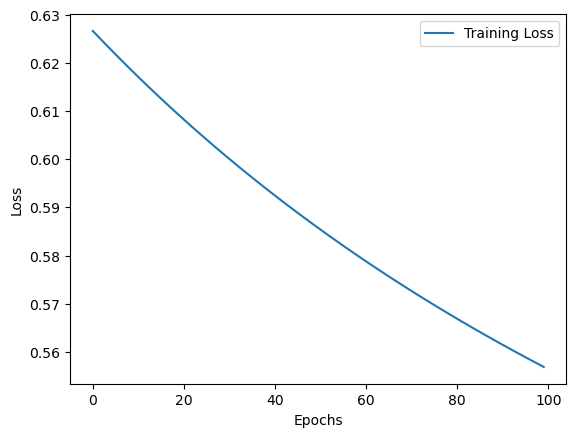

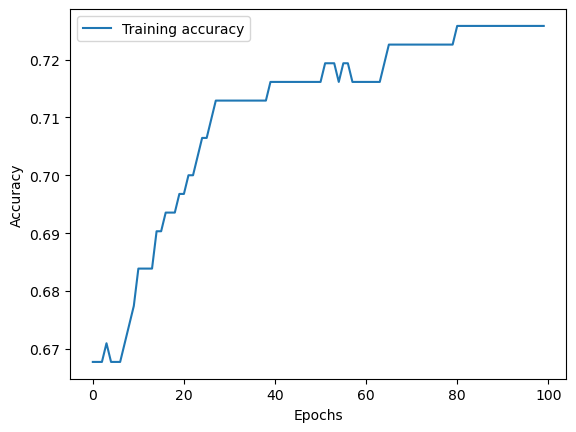

In [289]:

# 1) Design the model 
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, inputdim, ouputdim):
        super(LogisticRegression,self).__init__()
        self.linear = torch.nn.Linear(inputdim,ouputdim,dtype=torch.float64)
    
    def forward(self,x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
    model = LogisticRegression(X.shape[1],1)
    
    # loss and optimizer:
    learning_rate = 0.01 
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    
    # 3) Training loop:
    accs = []
    costs = []
    num_epochs = 100
    for epoch in range(num_epochs):
        # Forward Pass:
        yhat = model(X)
        loss = criterion(yhat,Y)
        
        # Save evaluation metrics:
        costs.append(loss)
        accs.append(accuracy(Y,yhat))
        
        # Upadates
        loss.backward()
        
        # Update weights:
        optimizer.step()
        
        # Zero the gradients:
        optimizer.zero_grad()
        
        if (epoch+1) % 10 == 0:
            print(f"epoch: {epoch+1}, loss = {loss.item():}")
        
    # some output
    with torch.no_grad():
        accs = np.array(accs)
        costs = np.array(costs)
        print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
        print("Training Cost (end): %f"%costs[-1].item())
        plt.figure(1)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(range(num_epochs),costs, label="Training Loss")
        plt.legend()
        plt.figure(2)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(range(num_epochs),accs, label="Training accuracy")
        plt.legend()

### 5. Tune Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

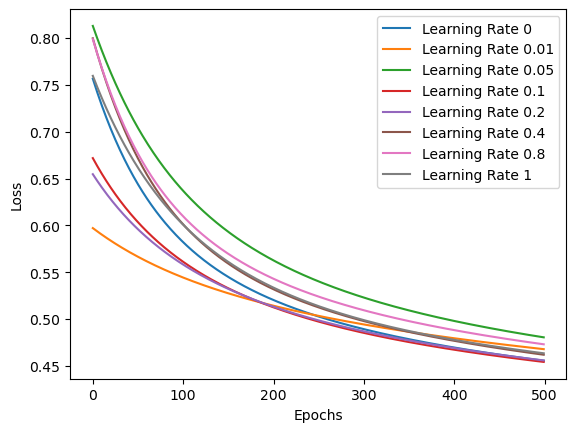

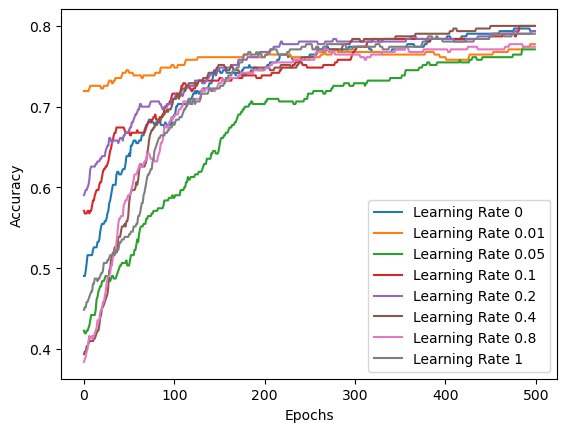

In [299]:
rates = [0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 1]
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, inputdim, ouputdim):
        super(LogisticRegression,self).__init__()
        self.linear = torch.nn.Linear(inputdim,ouputdim,dtype=torch.float64)
    
    def forward(self,x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def compute(X,Y,lr,epochs):
    
    model = LogisticRegression(X.shape[1],1)
     # loss and optimizer:
    learning_rate = 0.01 
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    # 3) Training loop:
    accs = []
    costs = []
    num_epochs = epochs
    for epoch in range(num_epochs):
        # Forward Pass:
        yhat = model(X)
        loss = criterion(yhat,Y)
        
        # Save evaluation metrics:
        costs.append(loss)
        accs.append(accuracy(Y,yhat))
        
        # Upadates
        loss.backward()
        
        # Update weights:
        optimizer.step()
        
        # Zero the gradients:
        optimizer.zero_grad()
        
    
    return costs, accs
        
        
    # some output
for lr in rates:
    costs, accs = compute(X,Y,lr,500)
    with torch.no_grad():
        accs = np.array(accs)
        costs = np.array(costs)
        plt.figure(1)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(range(500),costs, label="Learning Rate {}".format(lr))
        plt.legend()
        plt.figure(2)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(range(500),accs, label="Learning Rate {}".format(lr))
        plt.legend()

